In [28]:
import random
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import svd
from numpy.linalg import norm
from time import perf_counter
from sklearn.utils.extmath import randomized_svd
from tabulate import tabulate

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]
plt.style.use('default')

In [18]:
class Node:
    def __init__(self, rank=None, side=None, sMin=None, tMin=None, U=None, V=None, D=None):
        self.next: list[Node] = []

        self.sMin: int = sMin
        self.tMin: int = tMin
        self.side: int = side

        self.rank: int = rank
        self.U: np.ndarray[float] = U
        self.D: np.ndarray[float] = D
        self.V: np.ndarray[float] = V


def CompressMatrix(
    A: np.ndarray[float],
    U: np.ndarray[float],
    D: np.ndarray[float],
    V: np.ndarray[float],
    r: int,
    sMin: int,
    tMin: int,
):
    if np.allclose(A, np.zeros(A.shape)):
        return Node(rank=0, side=A.shape[0], sMin=sMin, tMin=tMin)

    return Node(
        rank=r,
        side=A.shape[0],
        sMin=sMin,
        tMin=tMin,
        U=U[:, :r],
        D=D[:r],
        V=V[:r, :],
    )


def CreateTree(A: np.ndarray[float], r: int, eps: float, sMin: int = 0, tMin: int = 0):
    n = A.shape[0]
    U, D, V = randomized_svd(A, r + 1)
    if len(D) <= r or D[r] < eps:
        v = CompressMatrix(A, U, D, V, len(D), sMin, tMin)
    else:
        v = Node(rank=None, side=n, sMin=sMin, tMin=tMin)
        v.next.append(CreateTree(A[: n // 2, : n // 2], r, eps, sMin, tMin))
        v.next.append(CreateTree(A[n // 2 :, : n // 2], r, eps, sMin + n // 2, tMin))
        v.next.append(CreateTree(A[: n // 2, n // 2 :], r, eps, sMin, tMin + n // 2))
        v.next.append(CreateTree(A[n // 2 :, n // 2 :], r, eps, sMin + n // 2, tMin + n // 2))
    return v


def DrawTree(root: Node, r: int, sid: int, p: float):
    n = root.side
    fig, ax = plt.subplots()
    ax.set_aspect("equal", "box")
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.set_title(
        r"$n=$"
        + f"{n}"
        + " , "
        + r"$r=$"
        + f"{r}"
        + " , "
        + r"Index of $\sigma_k$:"
        + f" {sid}"
        + " , "
        + f"No. nonzero entries: {p:.2f}"
    )

    def DrawTreeRecursive(root: Node):
        nonlocal ax

        if root.rank is None:  # Not a leaf -> draw grid lines
            x, y, d = root.sMin, root.tMin, root.side // 2
            ax.plot((x, x + 2 * d), (y + d, y + d), color="k", lw=0.6)
            ax.plot((x + d, x + d), (y, y + 2 * d), color="k", lw=0.6)

        elif root.rank > 0:  # Leaf with SVD decomposition -> fill block
            x, y, d = (root.sMin, root.tMin + root.side, root.side)
            lw = root.side / (6 * root.rank)
            for i in range(root.rank):
                ax.fill([x, x + d, x + d, x], [y, y, y - (i + 1) * lw, y - (i + 1) * lw], color="k")
                ax.fill([x, x + (i + 1) * lw, x + (i + 1) * lw, x], [y, y, y - d, y - d], color="k")

        elif root.rank == 0:  # Leaf with all 0s -> pass
            pass

        for node in root.next:
            DrawTreeRecursive(node)

    DrawTreeRecursive(root)
    fig.savefig(f"hm_{p:.2f}_{r}_{sid}.png")


def Decompress(root: Node):
    n = root.side
    A = np.zeros((n, n))

    def DecompressRecursive(root: Node):
        nonlocal A
        if root.rank is None:  # Not a leaf -> pass
            pass
        elif root.rank == 0:  # Leaf with all 0s -> pass
            pass
        elif root.rank > 0:
            s, t, side = root.sMin, root.tMin, root.side
            U, D, V = root.U, np.diag(root.D), root.V
            A[s : s + side, t : t + side] = U @ D @ V

        for node in root.next:
            DecompressRecursive(node)

    DecompressRecursive(root)
    return A

C:\Users\barto\AppData\Local\Temp\ipykernel_19696\883631542.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


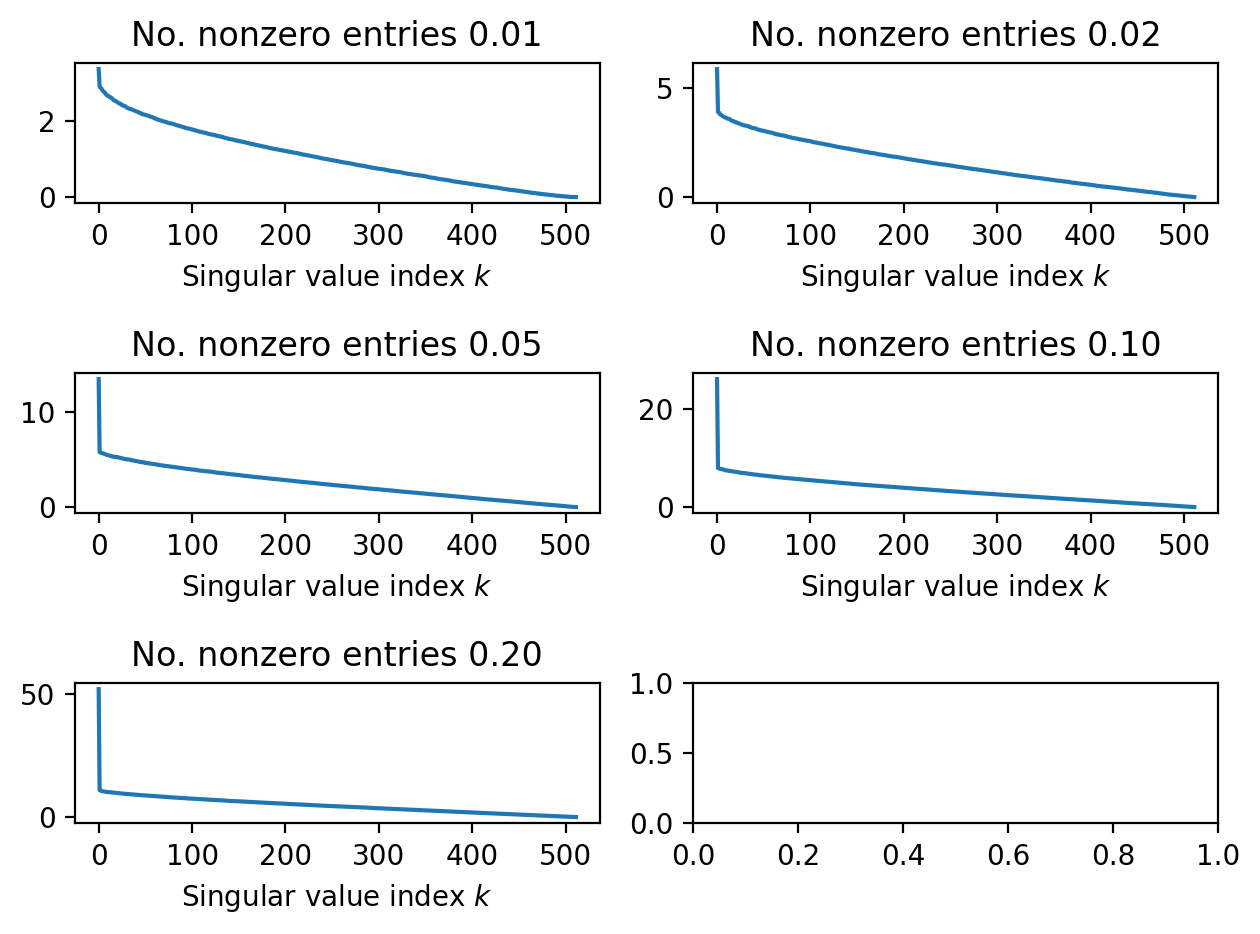

In [19]:
fig, ax = plt.subplots(3, 2)
for idx, p in enumerate((0.99, 0.98, 0.95, 0.90, 0.80)):
    n = 9
    A = np.random.rand(2**n, 2**n)
    for i, j in random.sample(
        [(x, y) for x in range(2**n) for y in range(2**n)], k=int(2 ** (2 * n) * p)
    ):
        A[i, j] = 0
    _, Sigma, _ = svd(A)
    
    ax[idx // 2][idx % 2].plot(np.arange(len(Sigma)), Sigma)
    ax[idx // 2][idx % 2].set_xlabel(r"Singular value index $k$")
    ax[idx // 2][idx % 2].set_title(f"No. nonzero entries {1-p:.2f}")

fig.tight_layout()
fig.show()

C:\Users\barto\AppData\Local\Temp\ipykernel_19696\2664657109.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


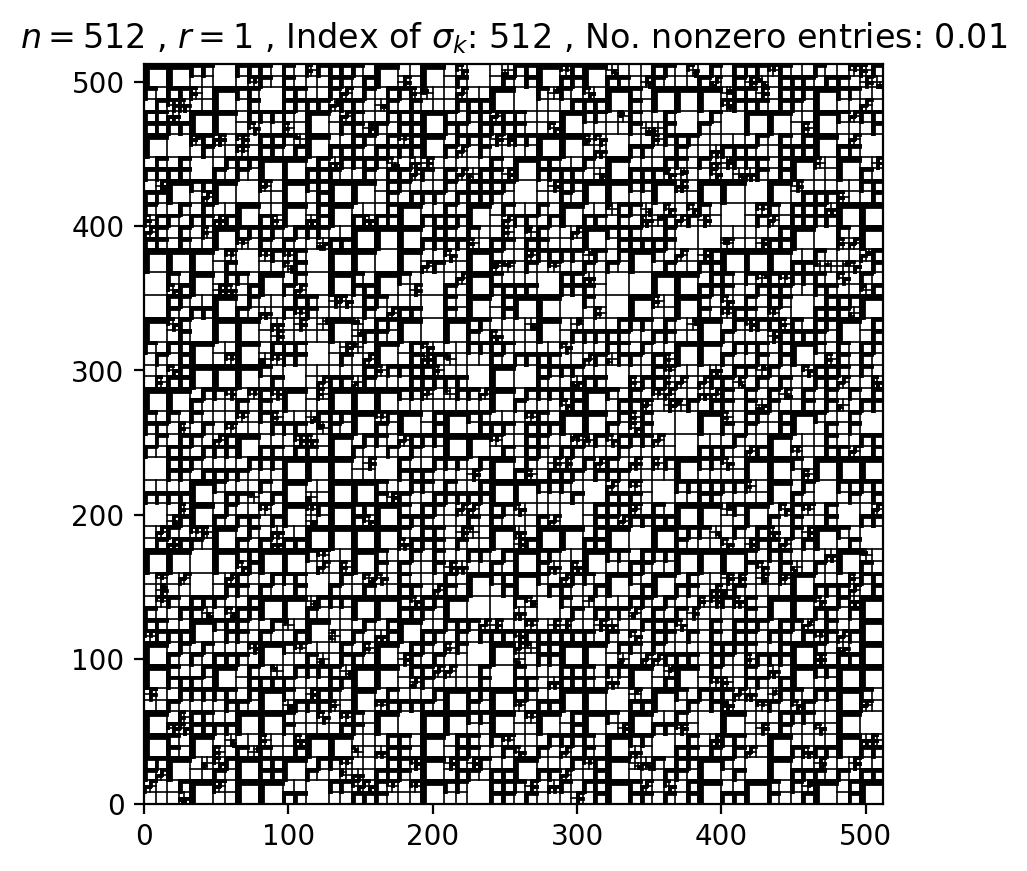

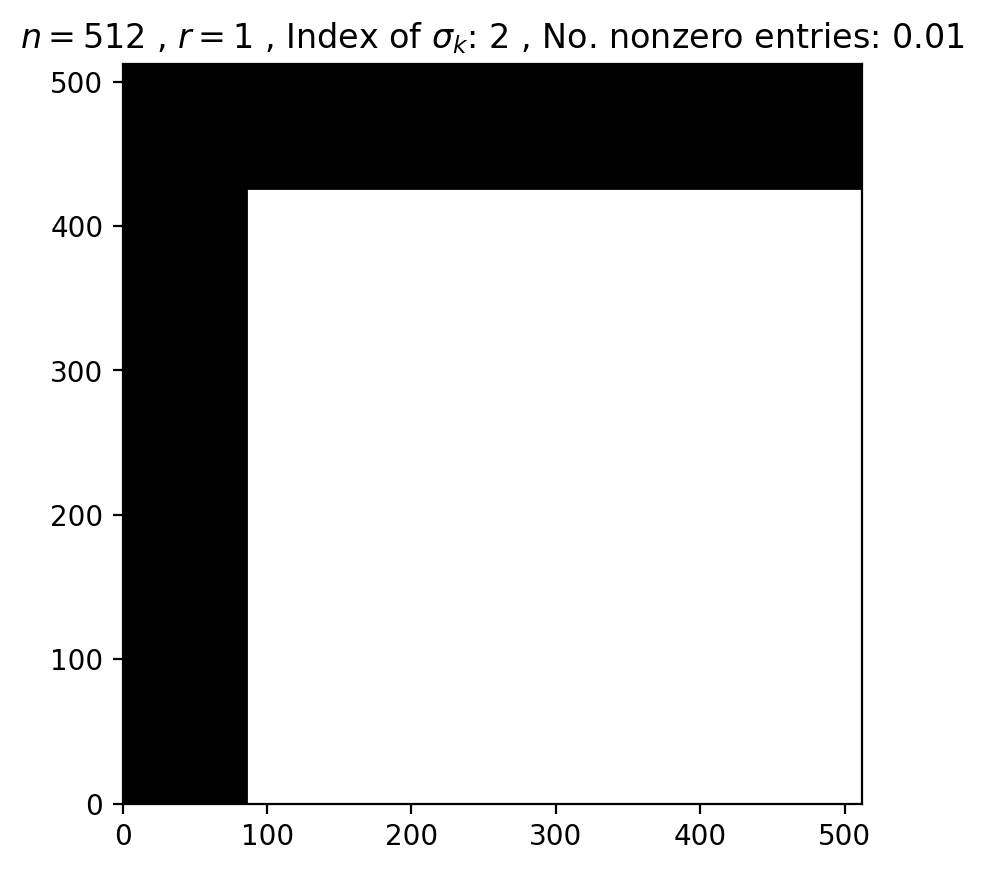

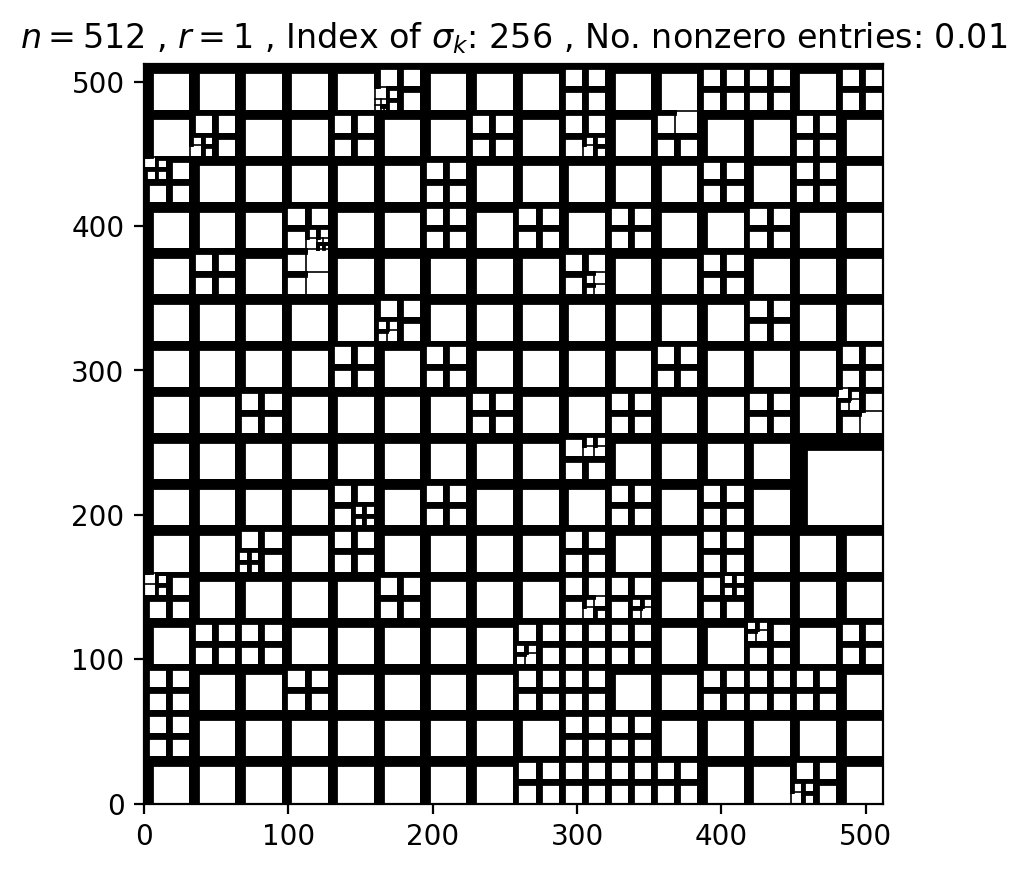

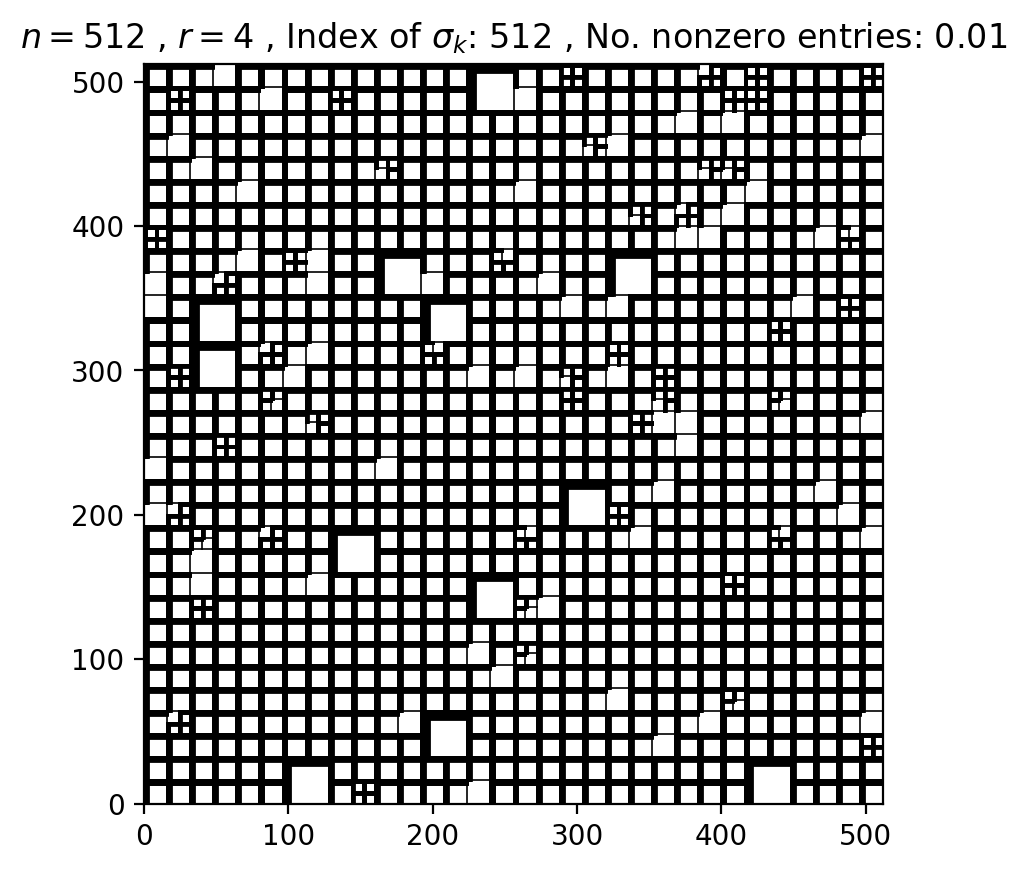

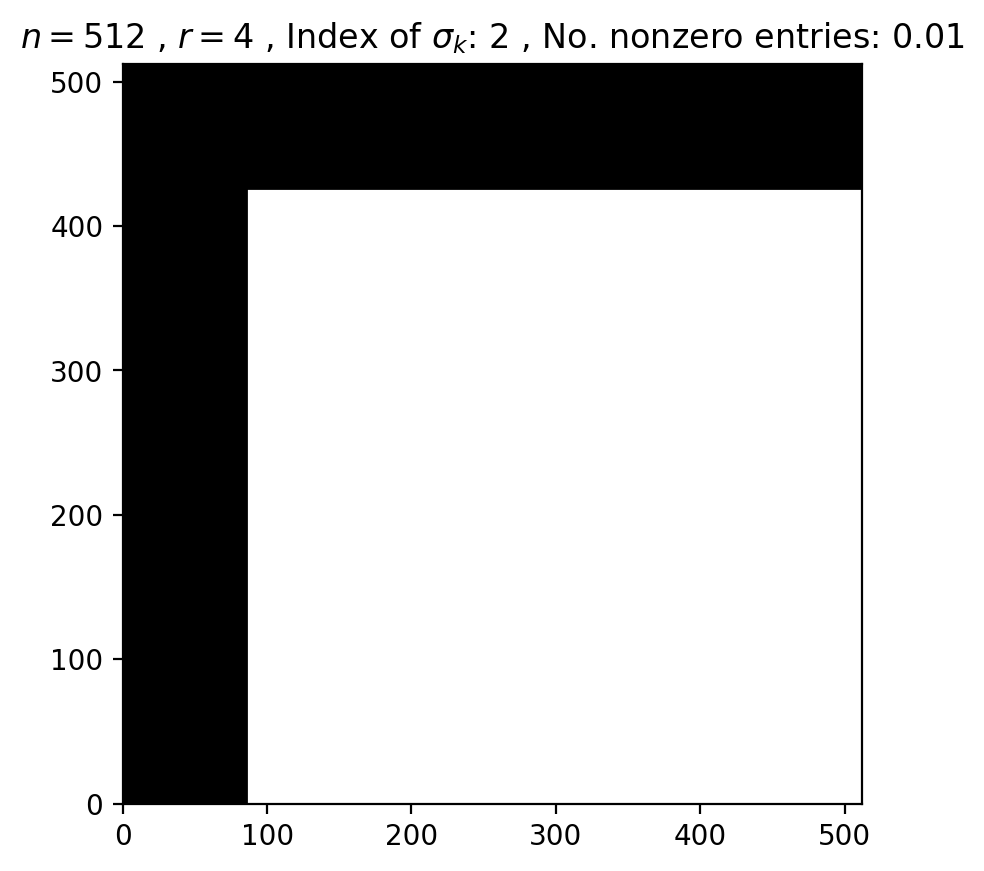

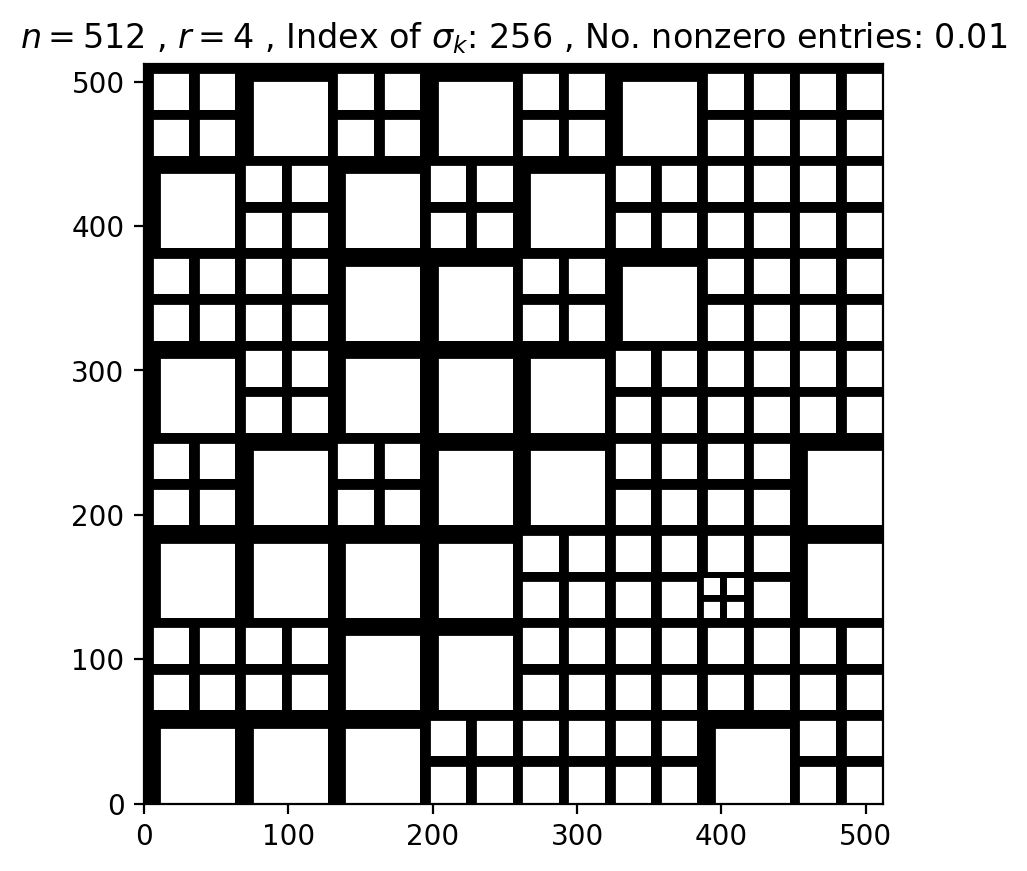

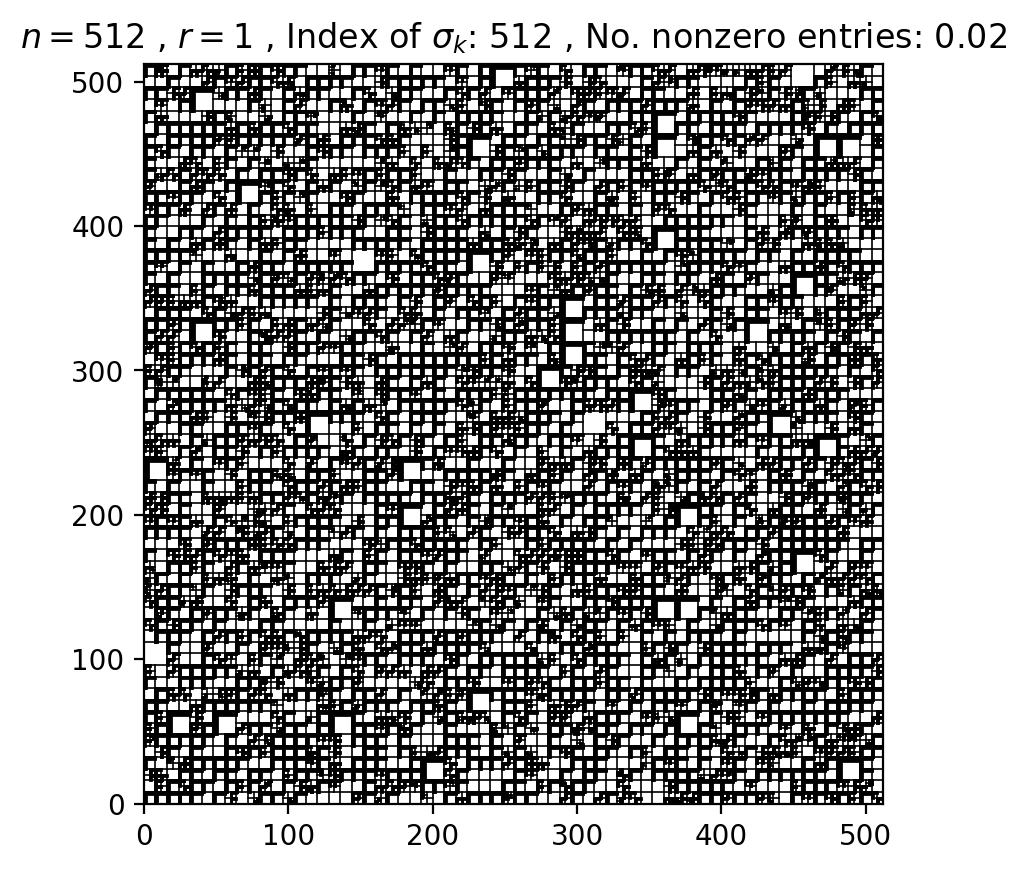

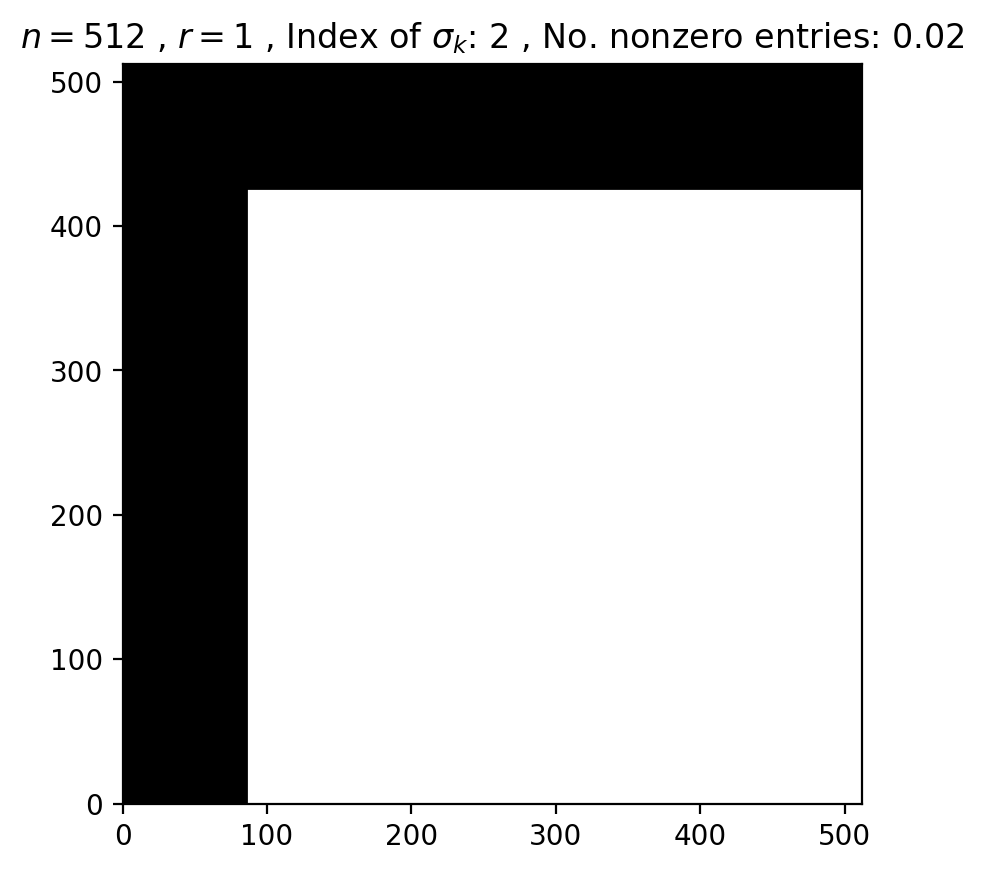

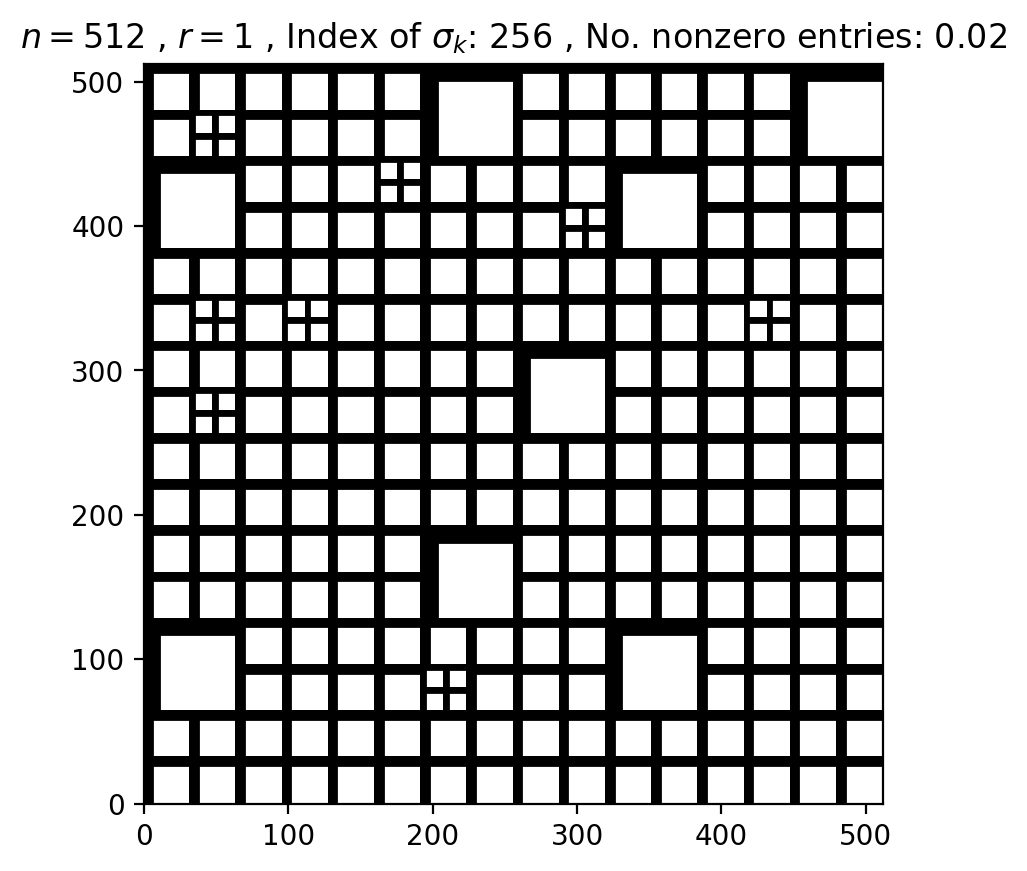

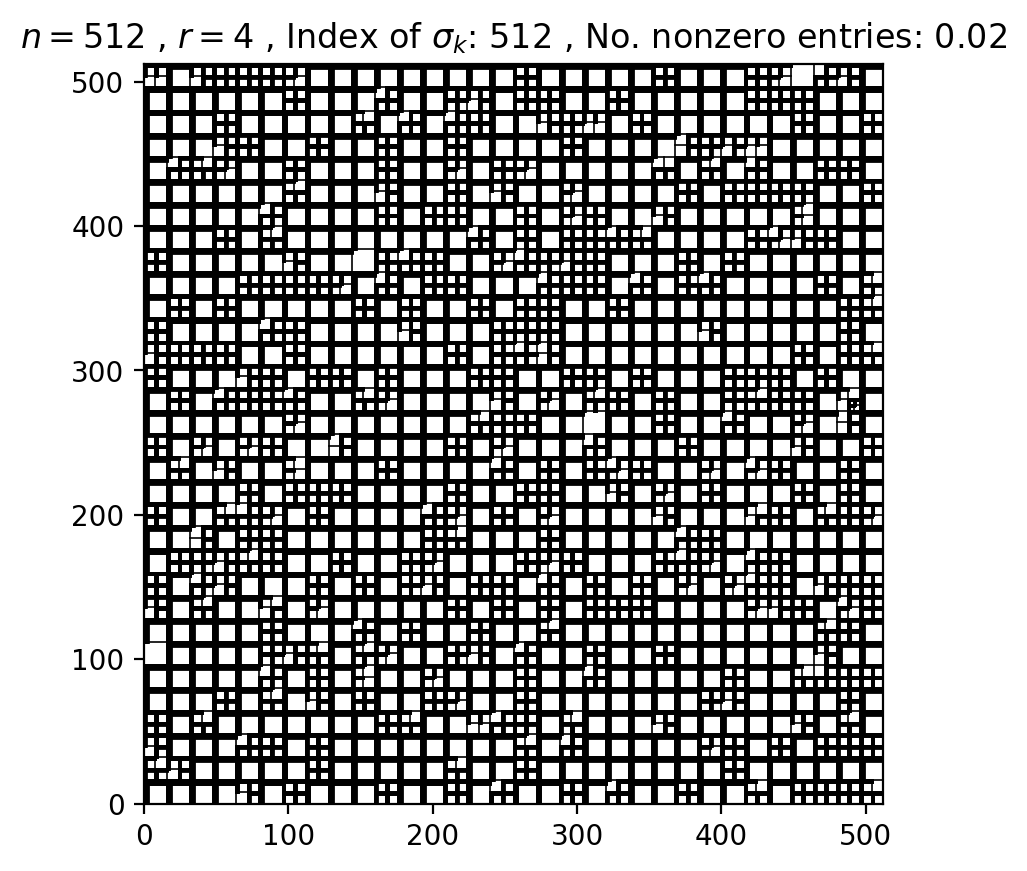

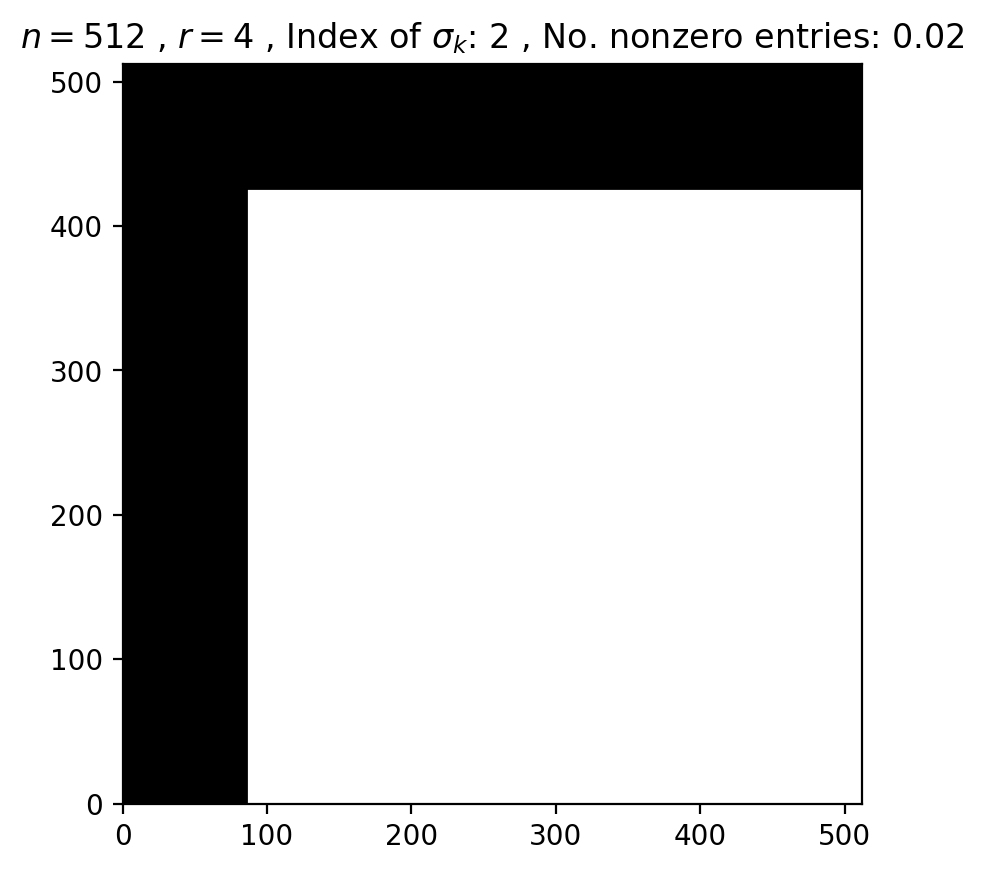

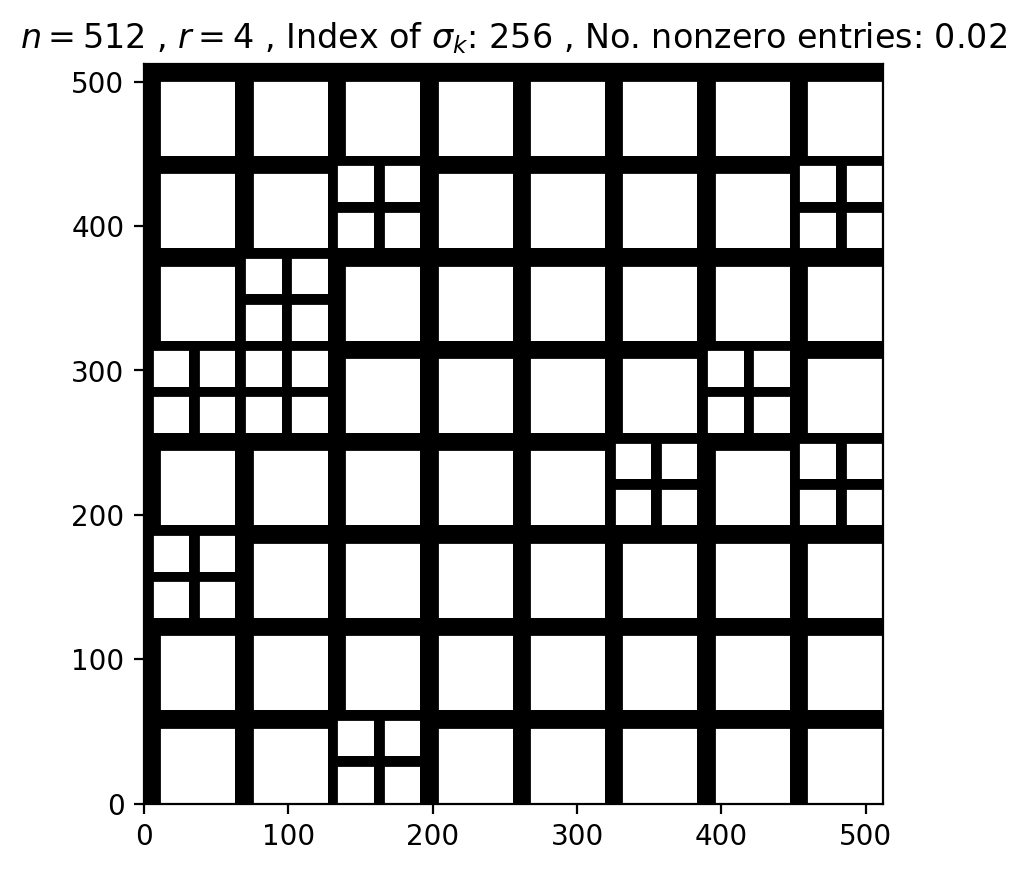

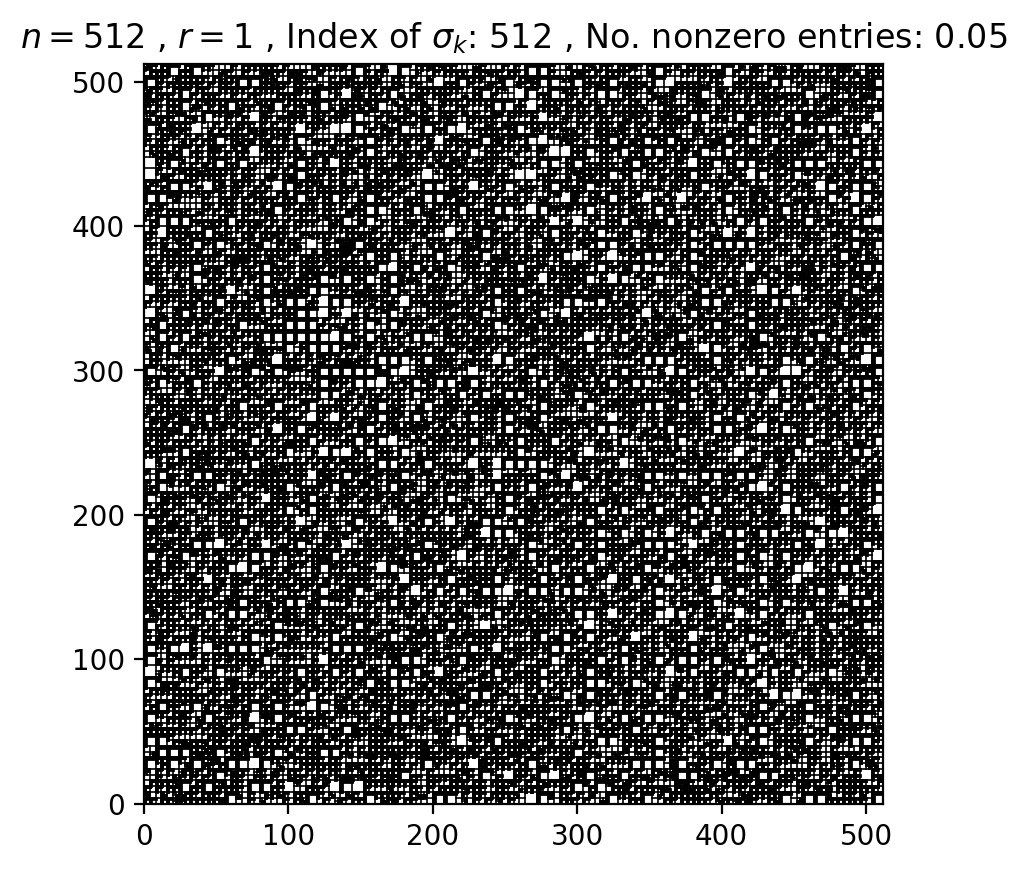

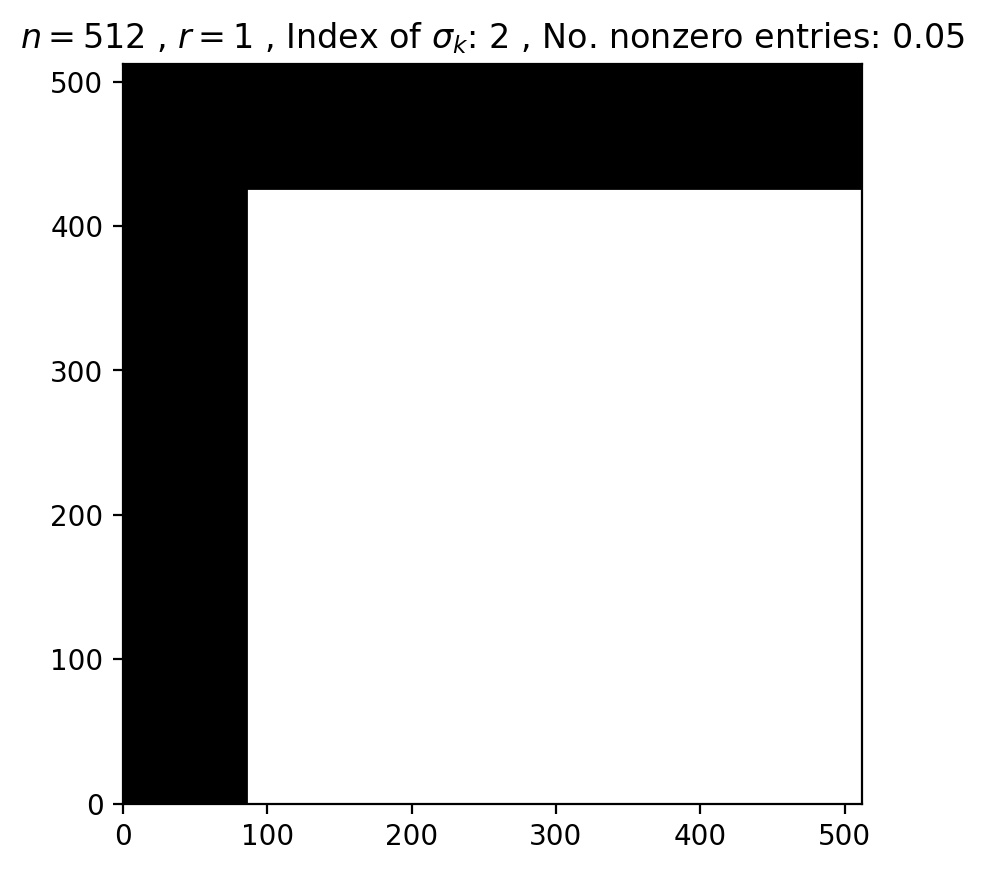

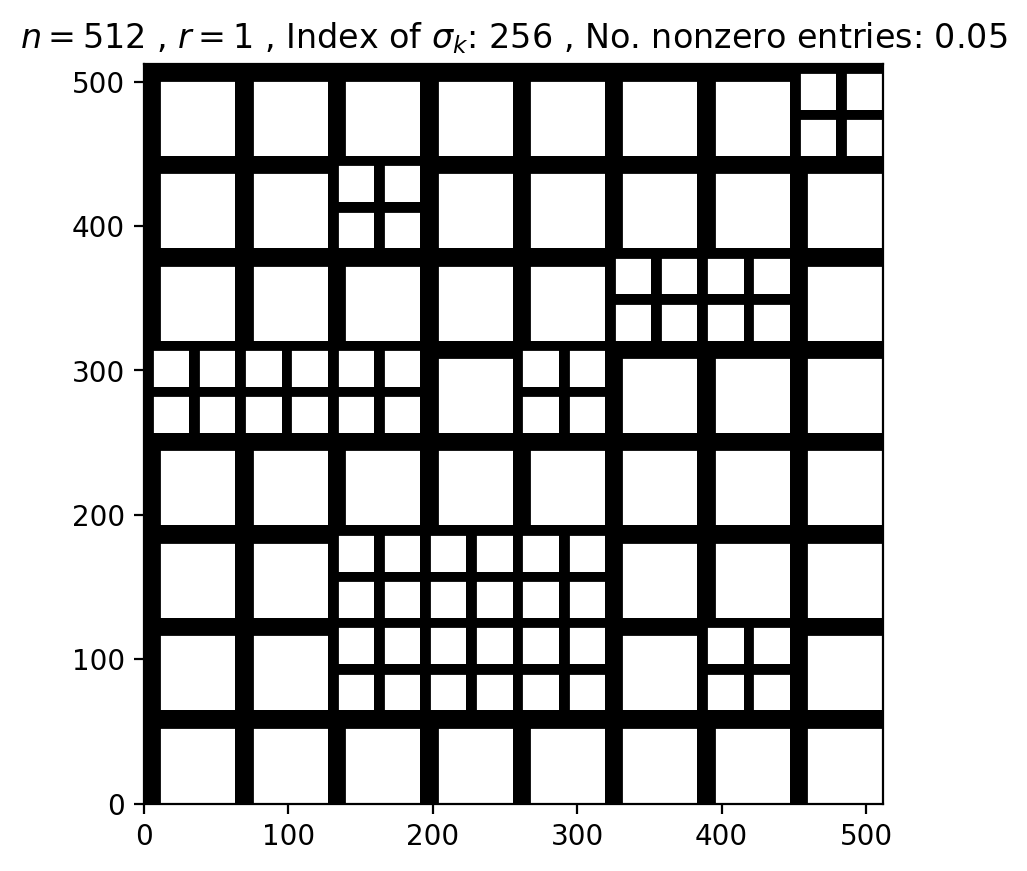

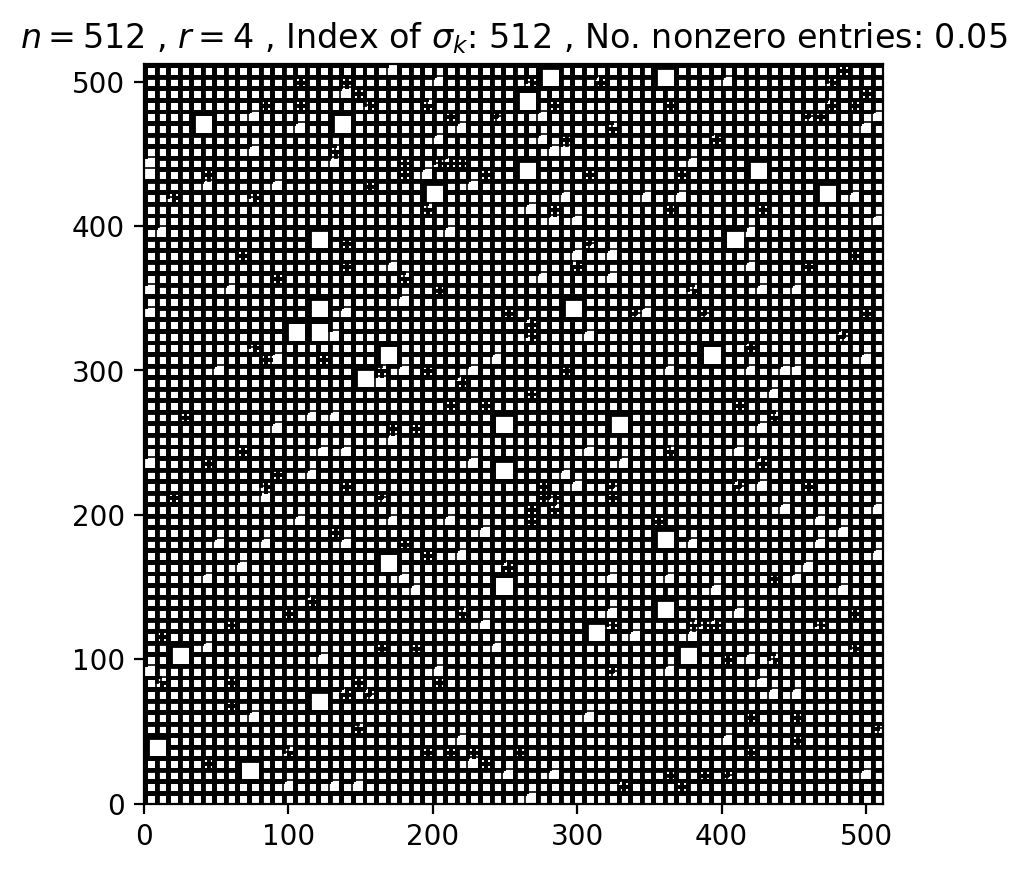

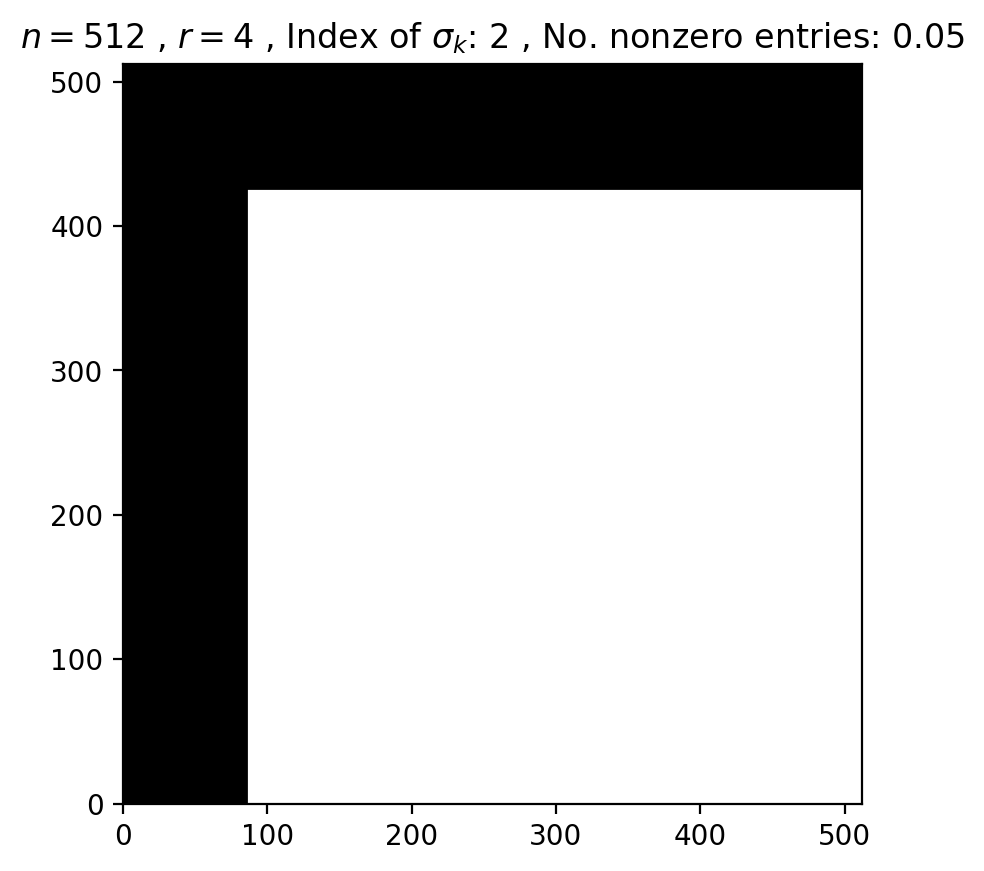

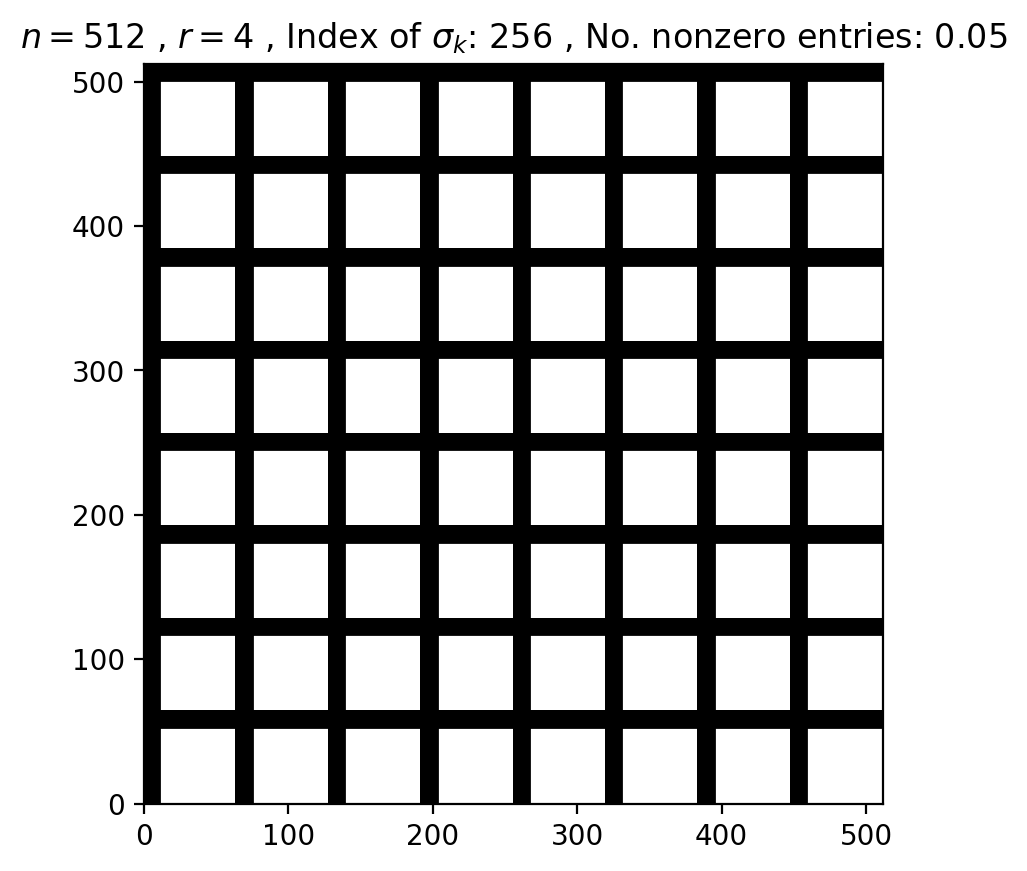

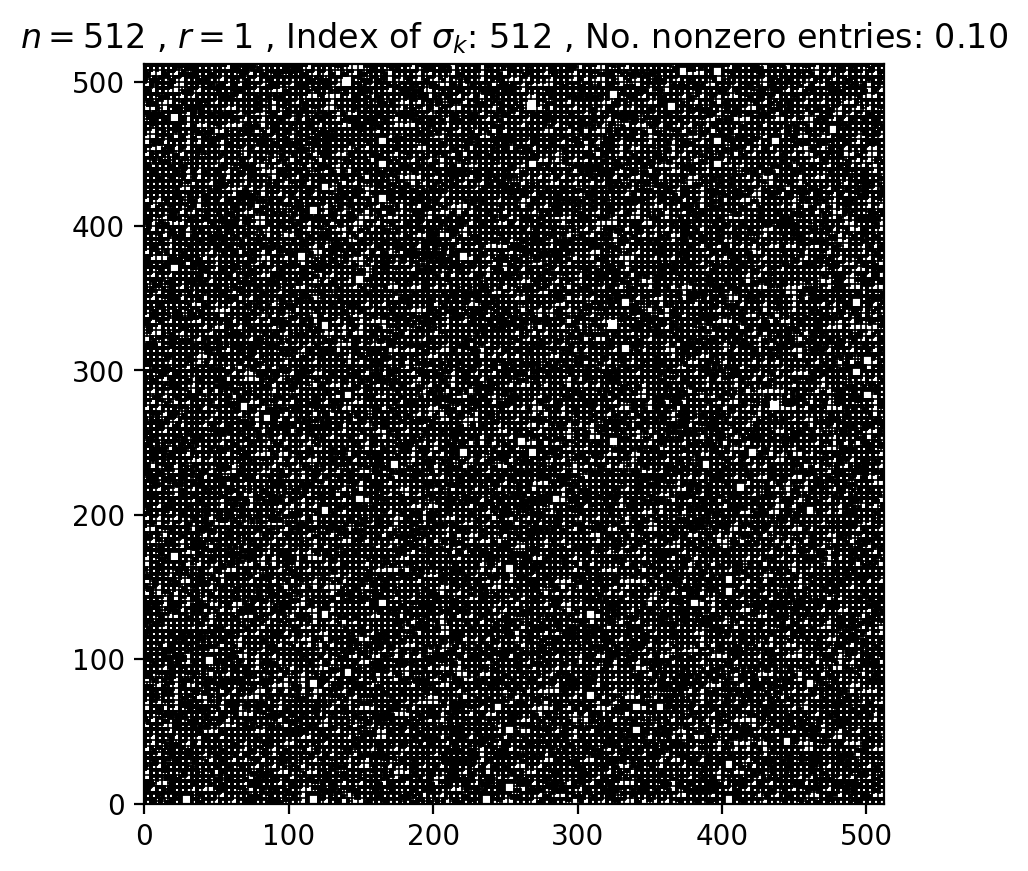

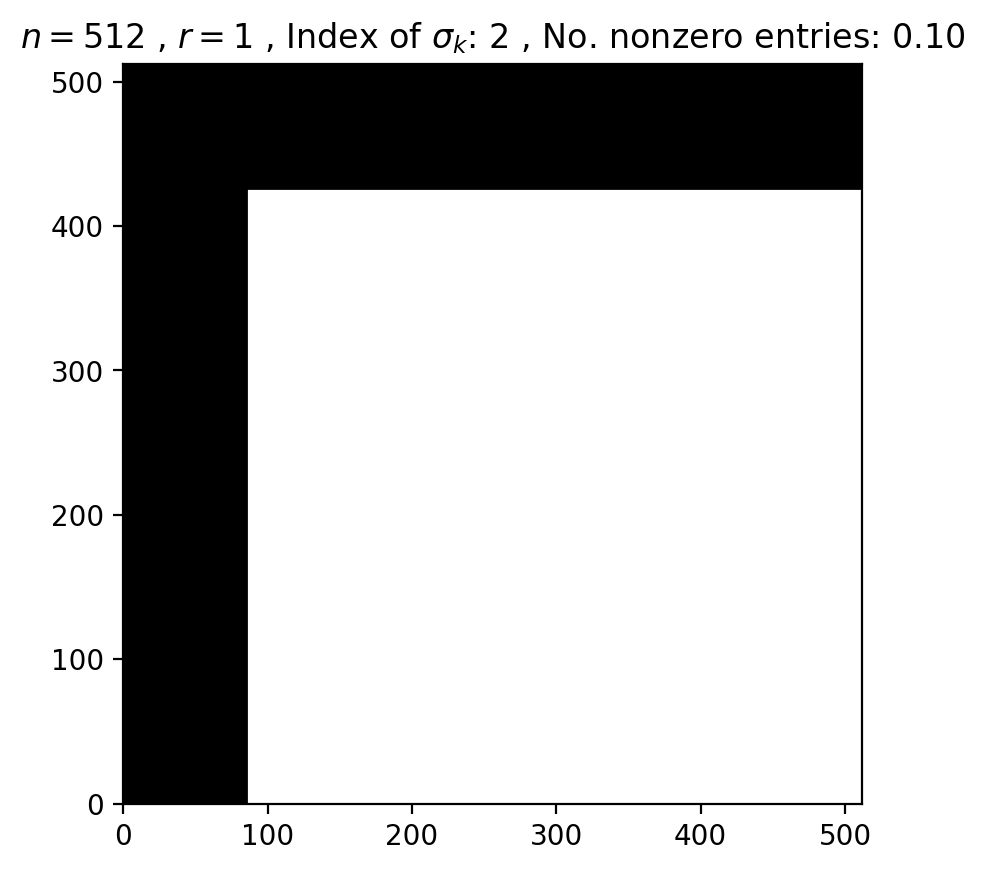

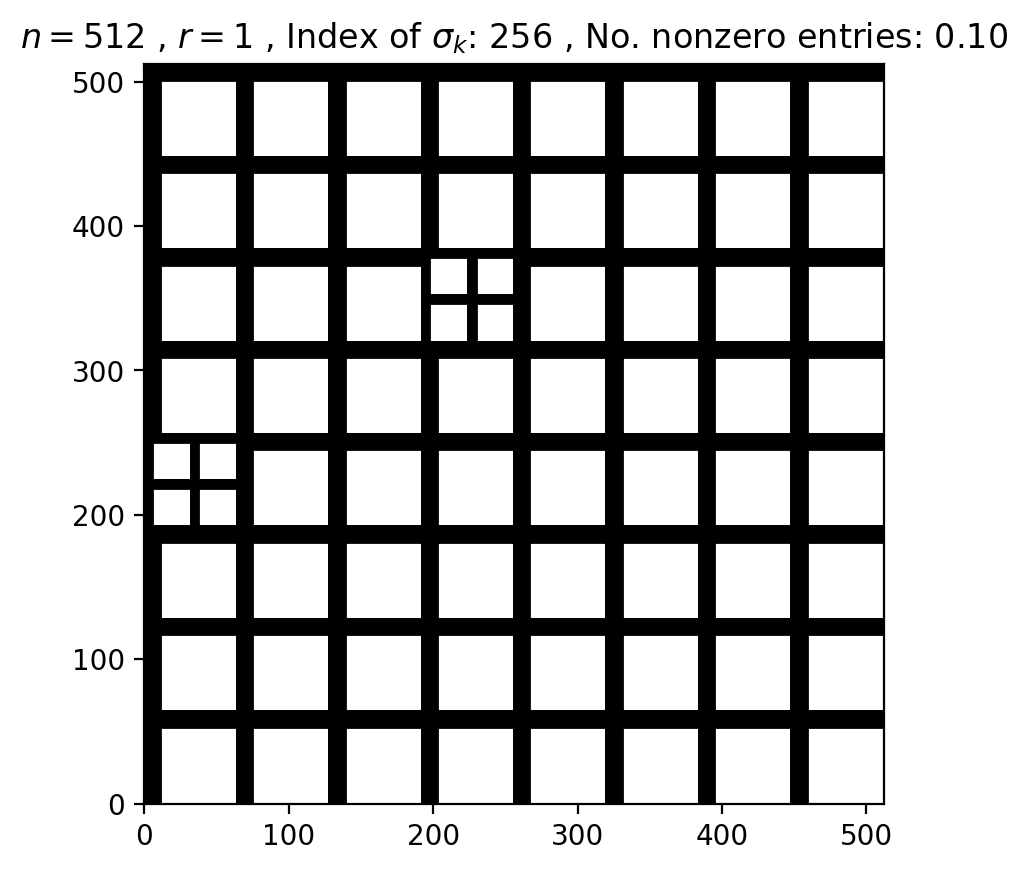

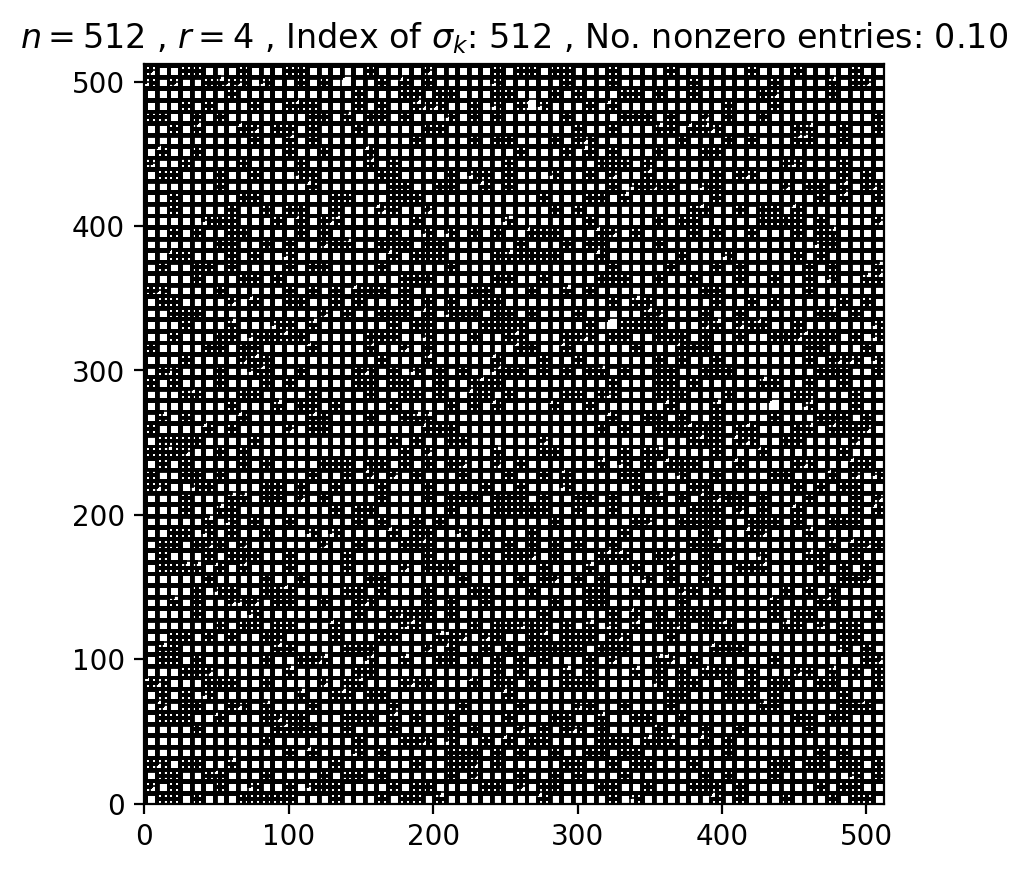

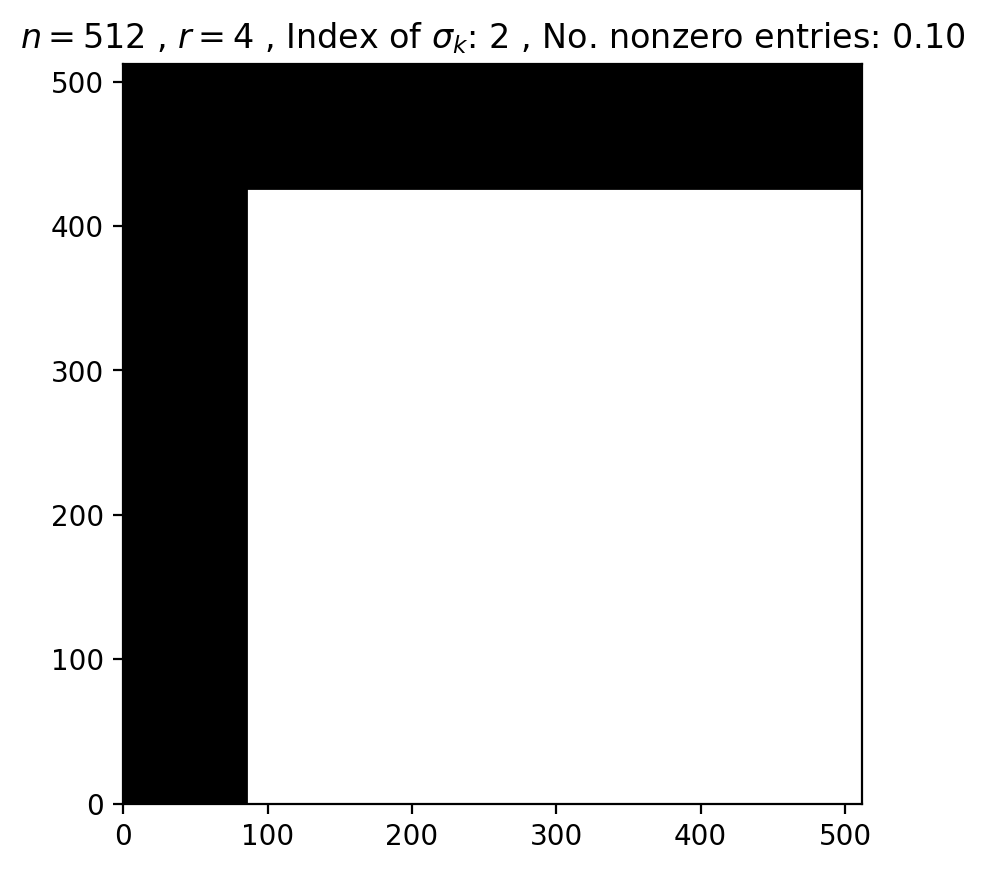

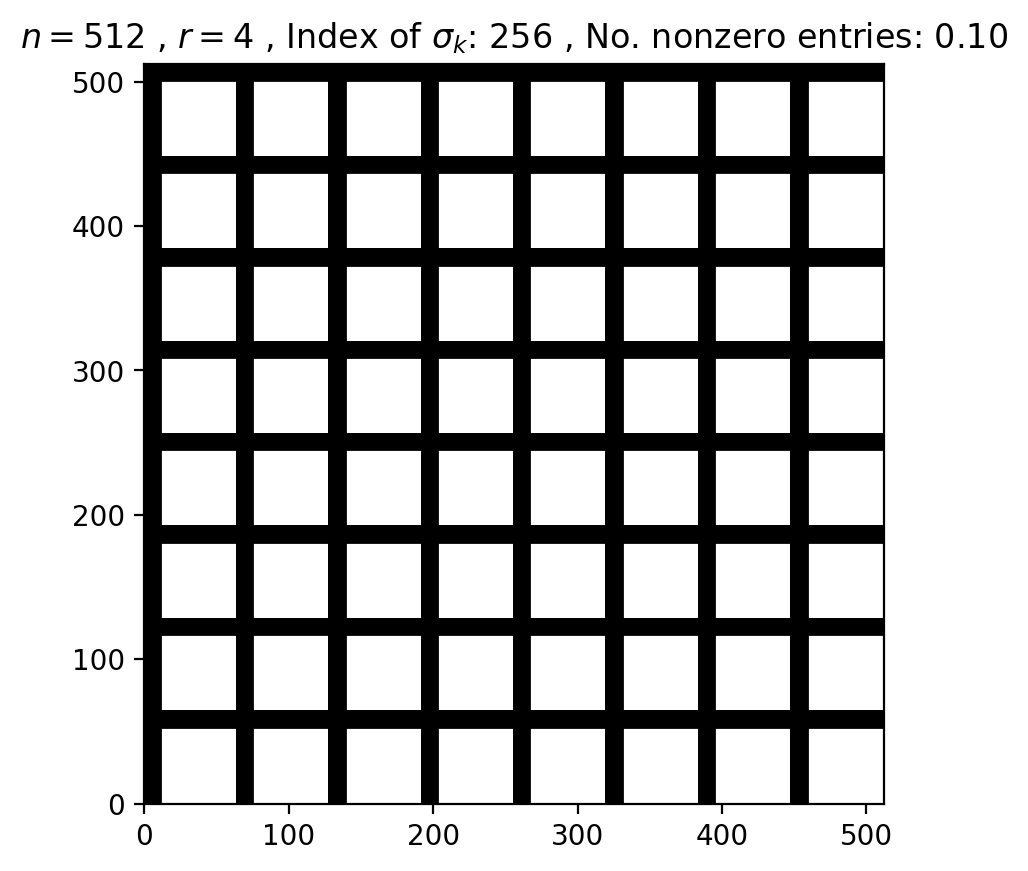

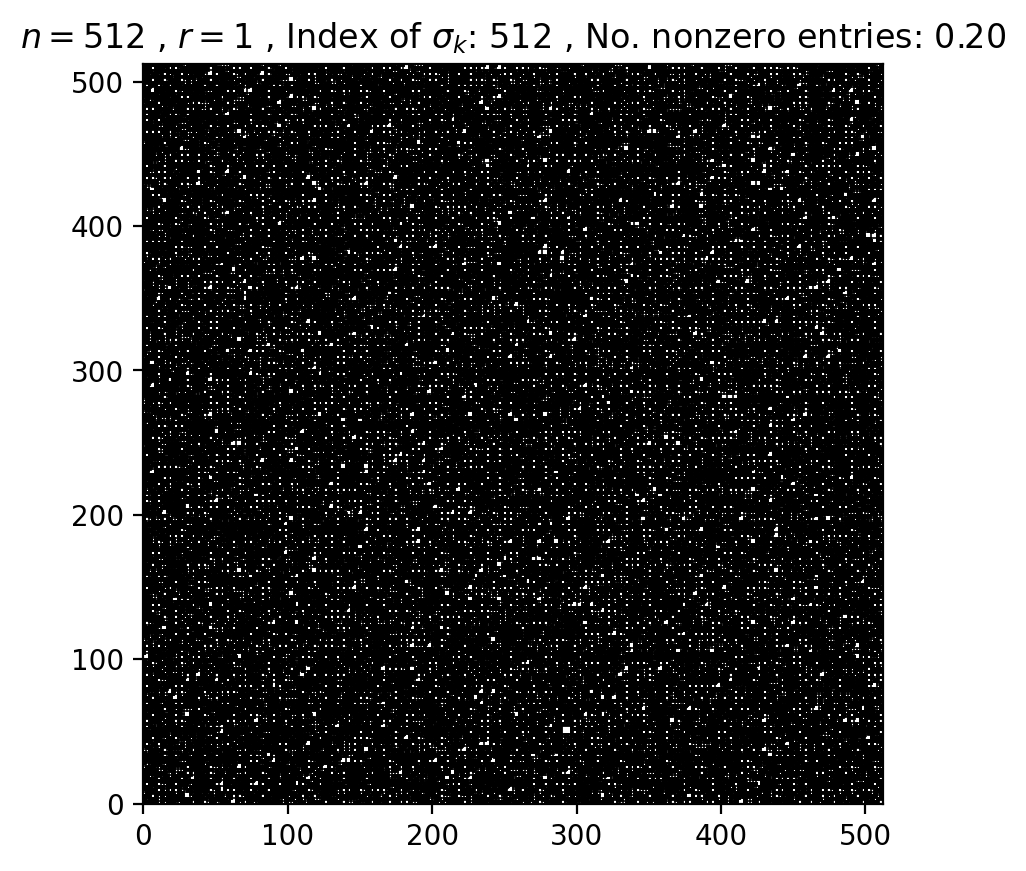

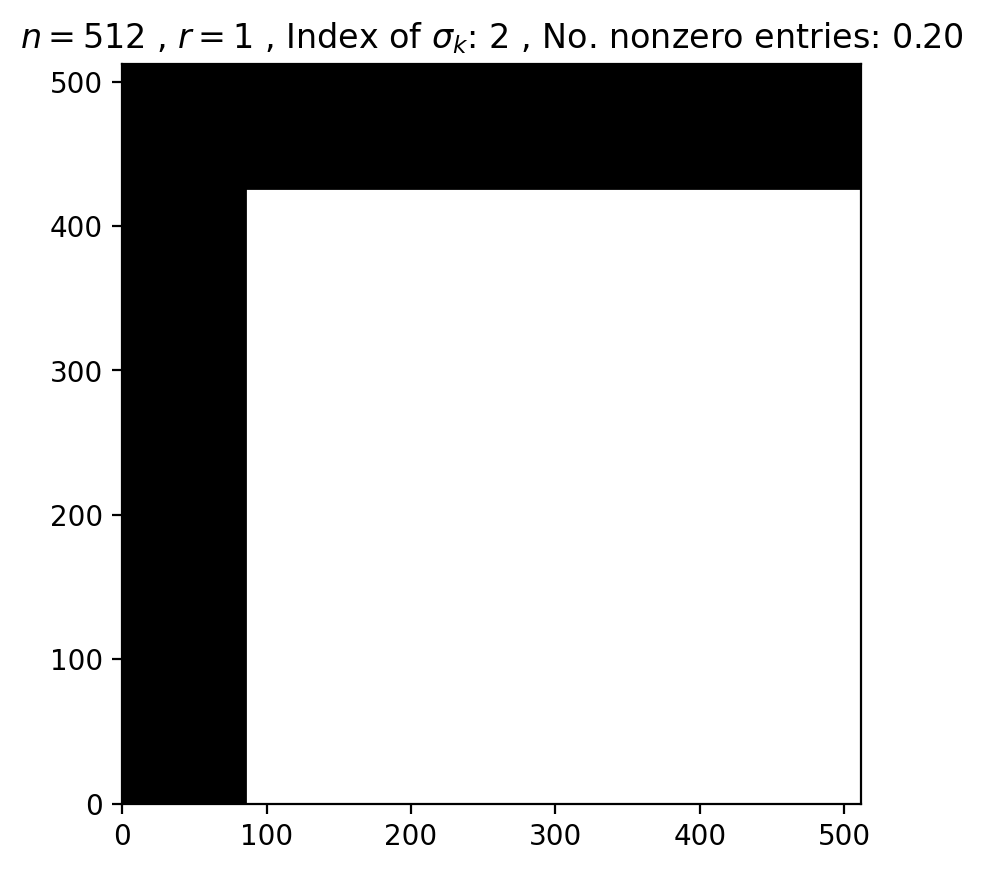

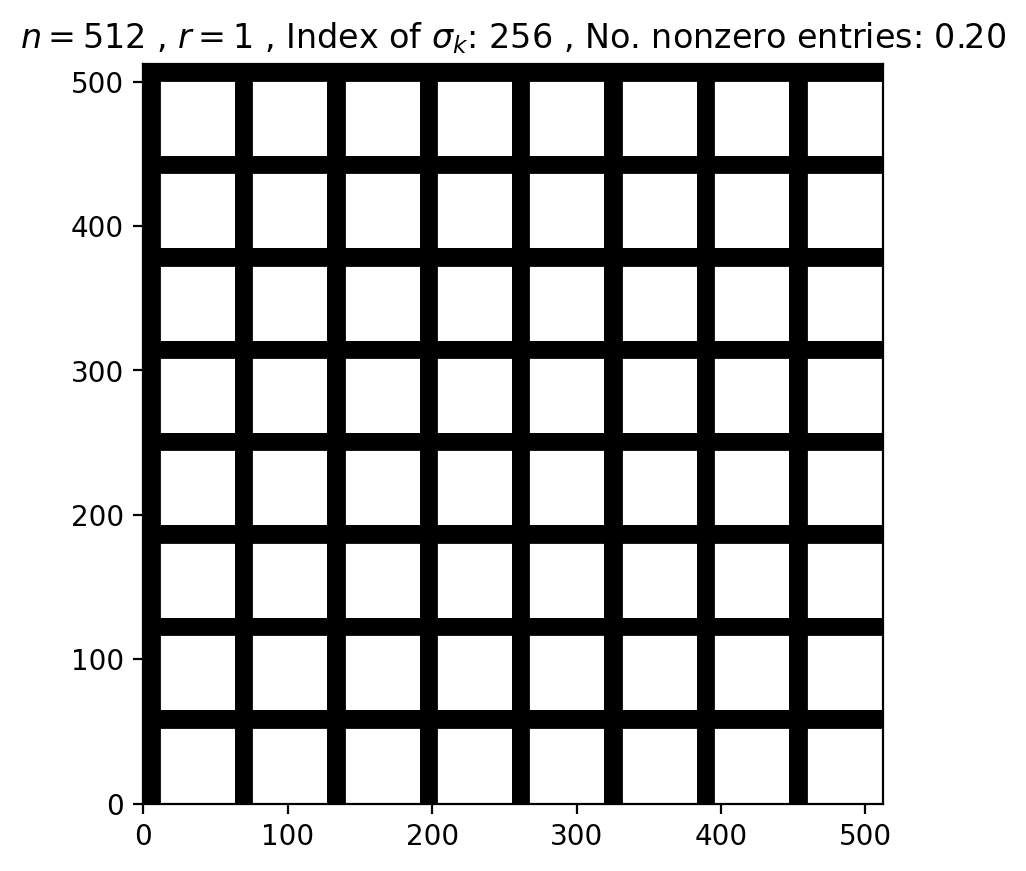

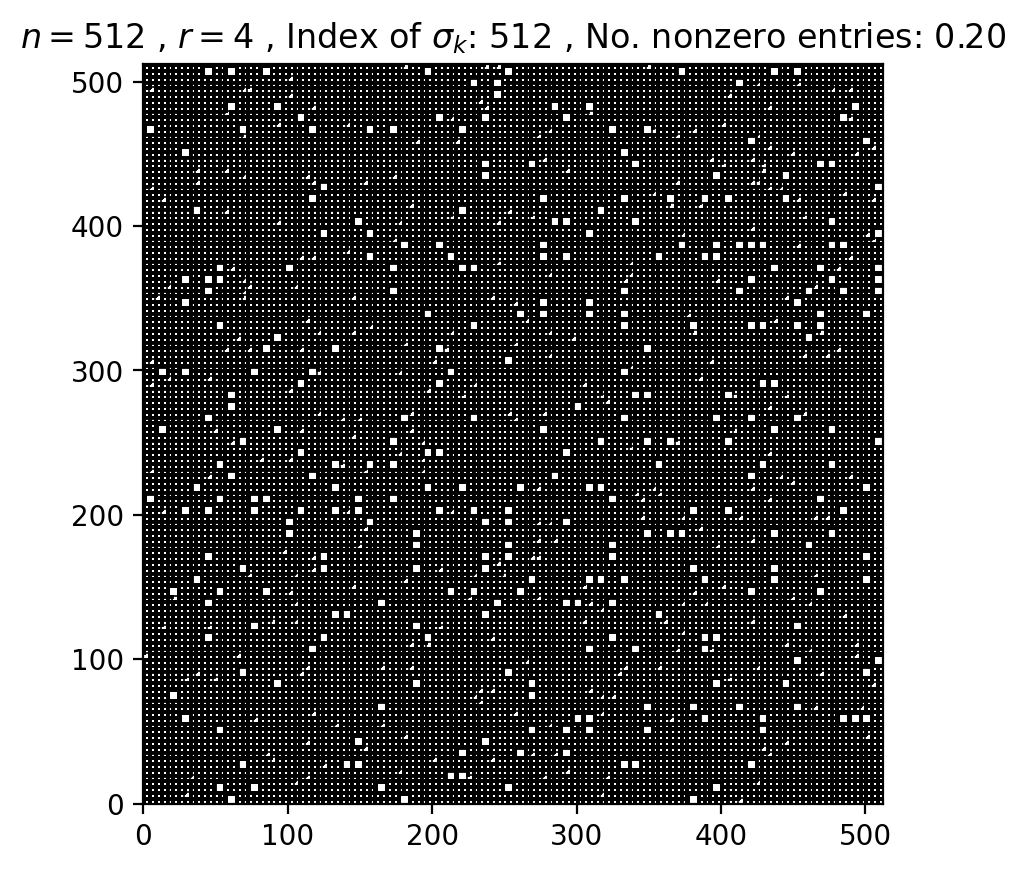

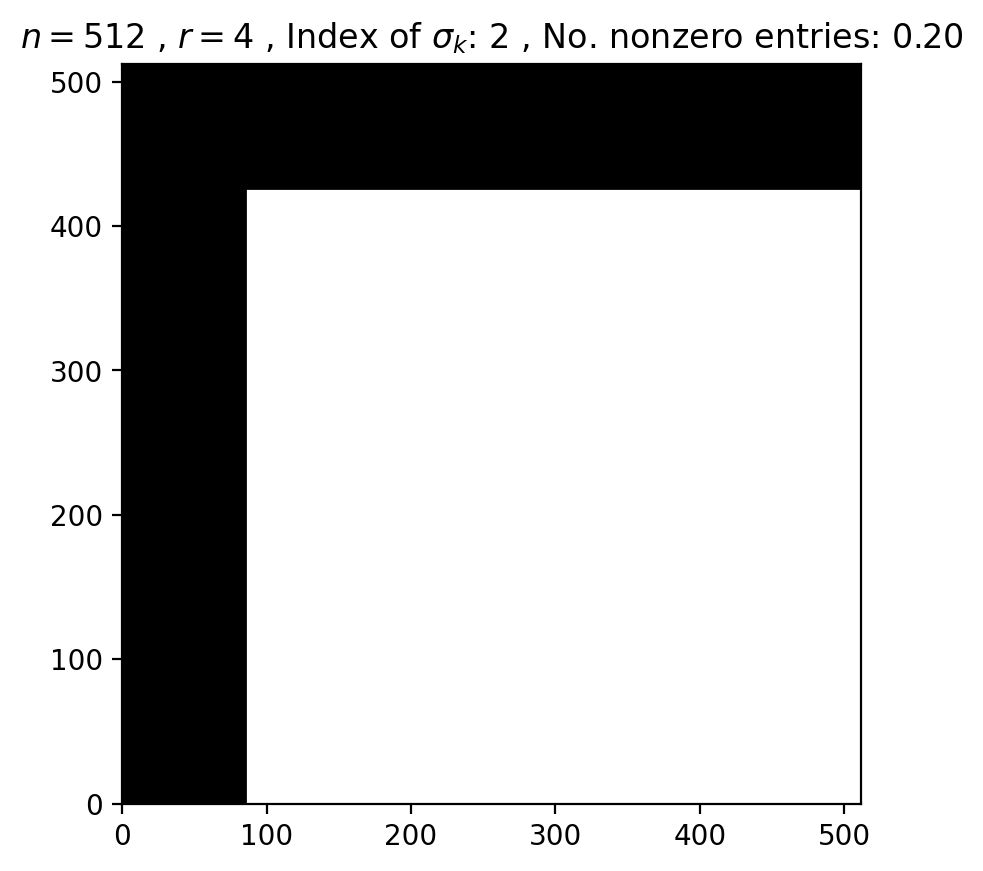

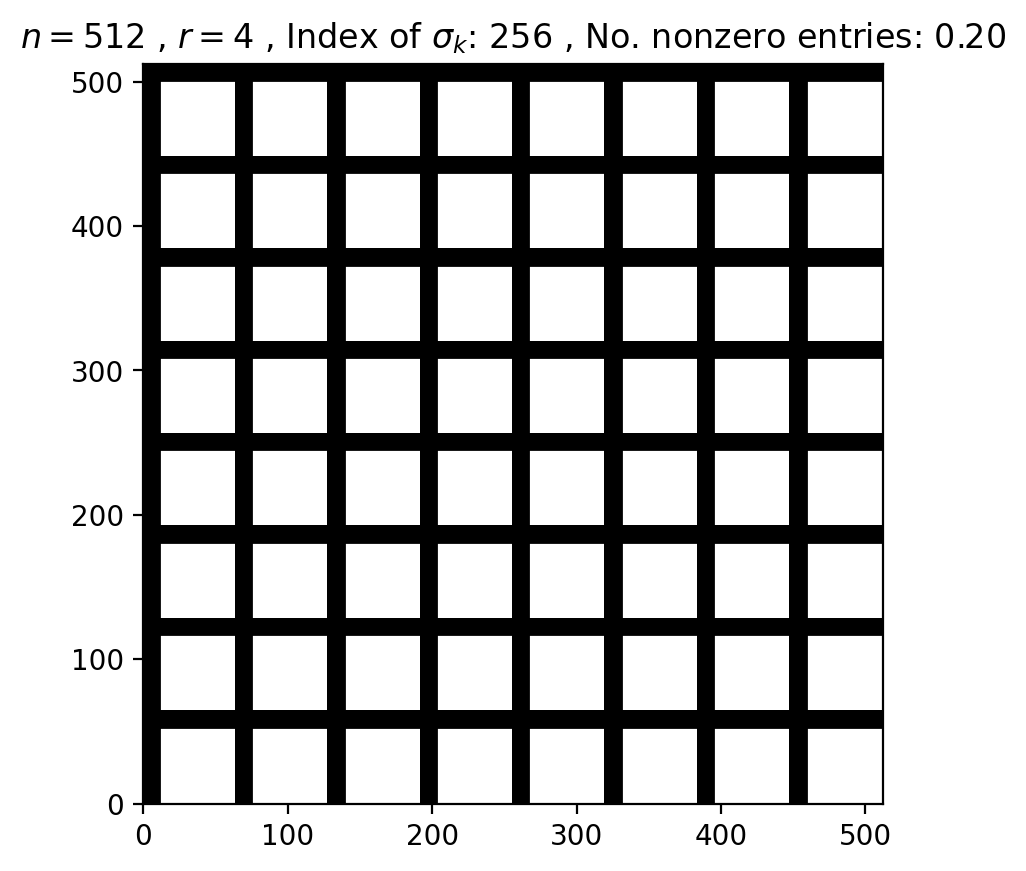

In [20]:
n = 9
data = []
for p in (0.99, 0.98, 0.95, 0.90, 0.80):
    A = np.random.rand(2**n, 2**n)
    for i, j in random.sample(
        [(x, y) for x in range(2**n) for y in range(2**n)], k=int(2 ** (2 * n) * p)
    ):
        A[i, j] = 0
    _, Sigma, _ = svd(A)

    for r in (1, 4):
        for sid in (len(Sigma) - 1, 1, len(Sigma) // 2):
            ts = perf_counter()
            root = CreateTree(A, r, Sigma[sid])
            te = perf_counter()
            B = Decompress(root)

            data.append((p, r, sid, te - ts, norm(A - B) / norm(A)))
            DrawTree(root, r, sid + 1 if sid != len(Sigma) // 2 else sid, 1 - p)

In [26]:
data = list(map(lambda x: list(x), data))
for i in range(len(data)):
    data[i] = list(data[i])
    if data[i][2] != 256:
        data[i][2] +=1


In [41]:
print(
    tabulate(
        data,
        headers=["p of zero entries", "Sigma_k index", "Time [s]", "Mean square error"],
        floatfmt=(".2f", "d", "d", ".2f", ".2e"),
        tablefmt="simple"
    )
)

        p of zero entries    Sigma_k index    Time [s]    Mean square error
----  -------------------  ---------------  ----------  -------------------
0.99                    1              512        1.07             1.45e-16
0.99                    1                2        0.01             9.88e-01
0.99                    1              256        0.26             5.60e-01
0.99                    4              512        0.53             7.35e-16
0.99                    4                2        0.01             9.74e-01
0.99                    4              256        0.11             5.02e-01
0.98                    1              512        1.89             1.50e-16
0.98                    1                2        0.01             9.86e-01
0.98                    1              256        0.17             7.78e-01
0.98                    4              512        0.69             7.58e-16
0.98                    4                2        0.01             9.73e-01
0.98        

True

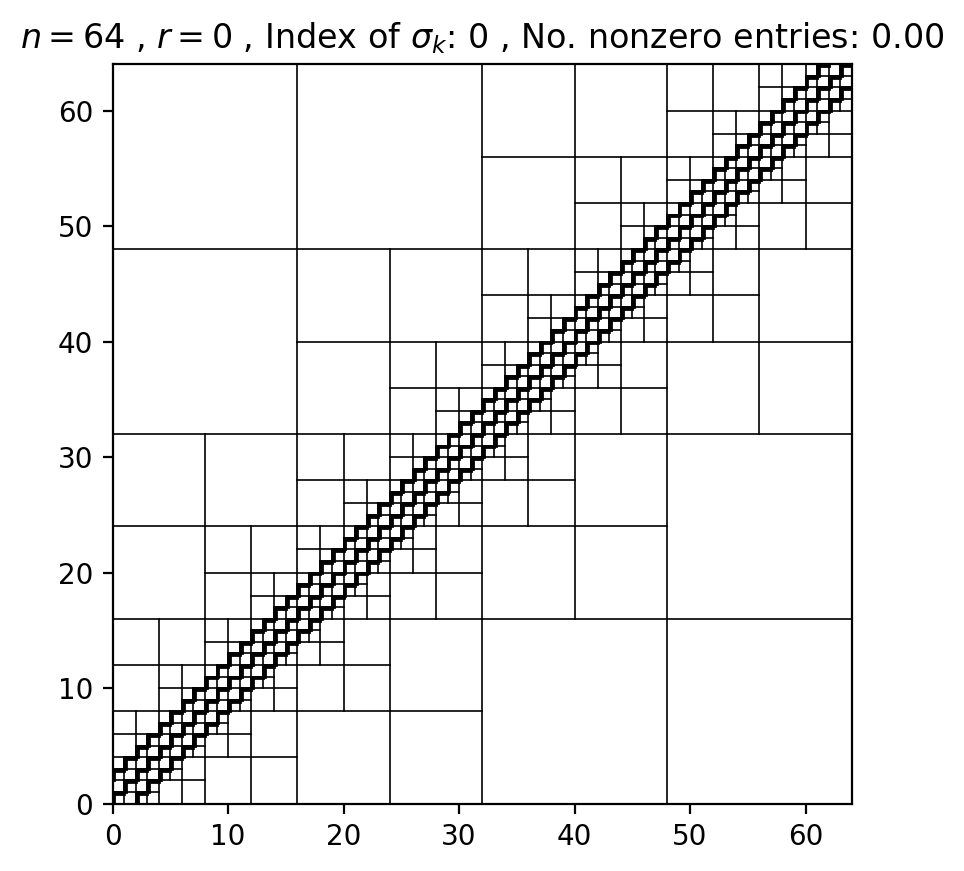

In [52]:
n = 2**6
A = np.zeros((n, n))

for i in range(n):
    A[i, i] = 1
    if i + 2 < n:
        A[i, i + 2] = 1
    if i - 2 >= 0:
        A[i, i - 2] = 2
root = CreateTree(A, 1, 0.001)
DrawTree(root, 0, 0, 0)
B = Decompress(root)
np.allclose(A, B)


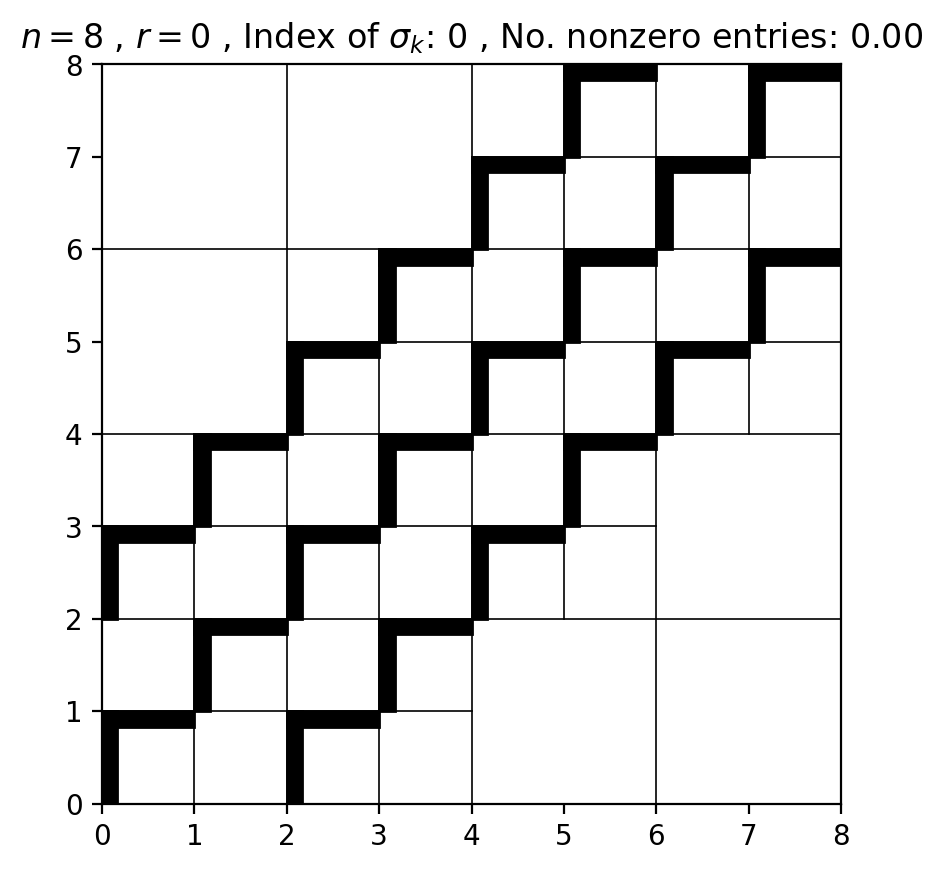

True